Anomaly Detection:
Detect anomalies in S&P 500 daily closing price

will be using LSTM based AutoEncoders

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#mounting drive to colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Download data from https://www.kaggle.com/pdquant/sp500-daily-19862018

In [0]:
spx = pd.read_csv("/content/drive/My Drive/google_colab/spx.csv",parse_dates=['date'])

In [26]:
spx.head(), spx.shape

(        date   close
 0 1986-01-02  209.59
 1 1986-01-03  210.88
 2 1986-01-06  210.65
 3 1986-01-07  213.80
 4 1986-01-08  207.97, (8192, 2))

Anomaly Detection:

Train an Autoencoder on normal data. Take a new data point and try to reconstruct it using the Autoencoder If the error for the new data point is above some threshold, we label the example as an anomaly.

Since our data is ime series so we will use LSTM.

In [27]:
spx.describe() # can see min, max closing points 

,close
count,8192.000000
mean,1070.897411
std,616.714534
min,203.490000
25%,458.632500
50%,1106.435000
75%,1388.132500
max,2872.870000


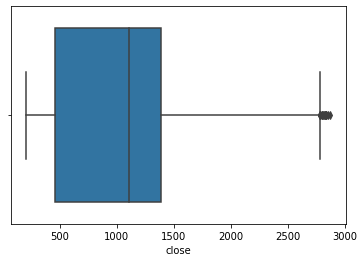

In [28]:
sns.boxplot(spx['close'])

In [0]:
#from above box plot we can see that:
#1. 0 to 25% has close values between 0 to near 500 
#2. 25 to 50% -> near 500 to near 1100
#3. 50 to 75% -> near 1100 to near 1400 
#4. rest 25% above 1400 to near 27500 
#5/ some outliers has close value more than 27500

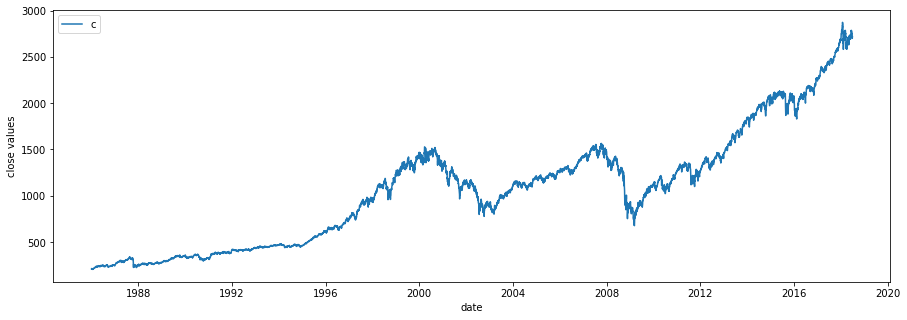

In [30]:
plt.figure(figsize=(15,5))
plt.plot(spx['date'], spx['close'])
plt.xlabel("date")
plt.ylabel("close values")
plt.legend('close price')

In [31]:
df = spx['close']
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train_close, test_close = df.iloc[0:train_size], df.iloc[train_size:len(df)]
train = train_close.values.reshape(-1,1)
test = test_close.values.reshape(-1,1)
print(train.shape, test.shape)

(6553, 1) (1639, 1)


In [32]:
scaler = StandardScaler()
scaler = scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
type(train)

numpy.ndarray

In [0]:
#input to lstm [samples, time_steps, n_features]
#lets create time stamp of 30


In [0]:
TIME_STEPS = 30

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [35]:
X_train, y_train = create_dataset(
  pd.DataFrame(train),
  pd.DataFrame(train),
  TIME_STEPS
)

X_test, y_test = create_dataset(
  pd.DataFrame(test),
  pd.DataFrame(test),
  TIME_STEPS
)

print(X_train.shape, y_train.shape, X_test.shape,y_test.shape )

(6523, 30, 1) (6523, 1) (1609, 30, 1) (1609, 1)


LSTM AutoEncoder 

In [0]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout,concatenate
from tensorflow.keras.layers import Conv1D,Conv2D, MaxPooling1D, Embedding,TimeDistributed,RepeatVector
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.regularizers import l2

In [0]:
def lstm_autoencoder():
  model = Sequential()
  model.add(LSTM(64,return_sequences=False,input_shape=(TIME_STEPS,1)))
  model.add(Dropout(rate=0.2))
  model.add(RepeatVector(TIME_STEPS))
  model.add(LSTM(64,return_sequences=True))
  #model.add(Dropout(rate=0.2))
  model.add(TimeDistributed(Dense(1)))
  model.compile(optimizer= 'adam', loss='mae')
  print (model.summary())
  return model


In [69]:
callback = EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True,mode="min")
model = lstm_autoencoder()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[callback],
    shuffle=False
)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 30, 64)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
184/184 [==============================] - 2s 9ms/step - loss: 0.1704 - val_loss: 0.2195
Epoch 2/50

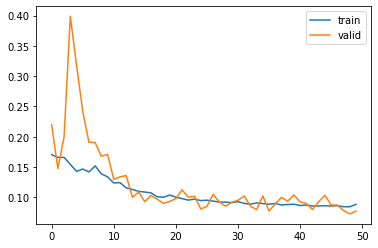

In [70]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend();

In [76]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

train_mae_loss.max() , test_mae_loss.max(), test_mae_loss.mean()

(0.6776178988273279, 1.945017611916703, 0.6827388525868479)

In [77]:
# error > threshold is anomaly 
THRESHOLD = 0.9
test_score_df = pd.DataFrame(index=pd.DataFrame(test)[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:]
test_score_df.head()

,loss,threshold,anomaly,close
30,0.145075,0.9,False,1.216856
31,0.143255,0.9,False,1.221625
32,0.139241,0.9,False,1.199313
33,0.108037,0.9,False,1.221194
34,0.124066,0.9,False,1.218150


Let's create nested LSTM autoencoder

In [0]:
def autoencoder():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True,input_shape=(TIME_STEPS,1)))
  model.add(Dropout(rate=0.3))
  model.add(LSTM(64))
  #model.add(Dropout(rate=0.3))
  model.add(RepeatVector(TIME_STEPS))
  model.add(LSTM(64,return_sequences=True))
  #model.add(Dropout(rate=0.3))
  model.add(LSTM(128,return_sequences=True))
  model.add(Dropout(rate=0.3))
  model.add(TimeDistributed(Dense(1)))
  model.compile(optimizer= 'adam', loss='mae')
  print (model.summary())
  return model

In [0]:
def scheduler(epoch):
  if epoch < 20:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))
lr_scheduler = LearningRateScheduler(scheduler) 
# This callback will stop the training when there is no improvement in
# the validation loss for 50 consecutive epochs and will save best weights
callback = EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True,mode="min") 

In [90]:
model = autoencoder()
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_split=0.1,
    callbacks=[callback,lr_scheduler],
    shuffle=False
)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 30, 128)           66560     
_________________________________________________________________
dropout_29 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 30, 64)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
lstm_37 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
dropout_30 (Dropout)         (None, 30, 128)         

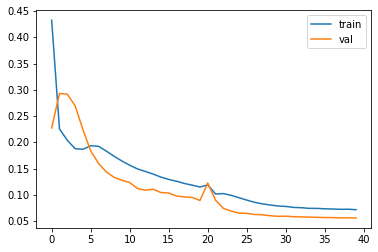

In [91]:
# loss vs epoch graph 
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend();

In [0]:
#calculating mae_loss on training data
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

In [96]:
#calculating mae_loss on testing data
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss.max(),test_mae_loss.mean()

(1.9663771458175243, 0.6355369017632351)

In [99]:
THRESHOLD = 1.2
test_score_df = pd.DataFrame(index=pd.DataFrame(test)[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:]
test_score_df.head()

,loss,threshold,anomaly,close
30,0.097354,1.2,False,1.216856
31,0.099904,1.2,False,1.221625
32,0.098583,1.2,False,1.199313
33,0.098145,1.2,False,1.221194
34,0.095802,1.2,False,1.218150


In [0]:
# error > threshold is anomaly 